In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

In [2]:
train_hypo_datapath ="1A.english.training.data.txt"
train_hyper_datapath ="1A.english.training.gold.txt"
train_vocab_datapath ="1A.english.vocabulary.txt"

In [3]:
class Hypernymy_Dataset(Dataset):
    def __init__(self, HYPONYMS_FILENAME, HYPERNYMS_FILENAME, VOCAB_FILENAME, num_negs=5):
        self.hyponyms = [line.strip().split("\t")[0] for line in self.read_file(HYPONYMS_FILENAME)]
        self.hypernyms = [line.strip().split("\t") for line in self.read_file(HYPERNYMS_FILENAME)]
        self.vocab = list(set([line.strip().split("\t")[0] for line in self.read_file(VOCAB_FILENAME)]))
        self.all_hypernyms = self.merge_hypernyms()
        self.num_negs = num_negs
        self.word_id_map = dict()
        self.id_word_map = dict()
        self.data_size = len(self.hyponyms)
        self.generate_mappings()

    def read_file(self,FILENAME):
        f = open(FILENAME,"r")
        lines = f.readlines()
        f.close()
        modified_lines = []
        for line in lines:
            words = line.strip().split("\t")
            modified_line = ""
            for word in words:
                word=word.lower()
                underscored_word = "_".join(word.split(" "))
                modified_line = modified_line + underscored_word + "\t"
            modified_lines.append(modified_line)
        return modified_lines

    def merge_hypernyms(self):
        all_hypernyms = []
        for hypers in self.hypernyms:
            all_hypernyms = all_hypernyms + hypers
        return list(set(all_hypernyms))

    def generate_mappings(self):
        for ndx, word in enumerate(self.vocab):
            self.word_id_map[word] = ndx
            self.id_word_map[ndx] = word

    def get_negative_samples(self, ndx):
        positives = self.hypernyms[ndx]
        negatives = []
        count = 0
        lo = self.num_negs * len(positives)
        while count < lo:
            rand_neg = self.all_hypernyms[np.random.randint(0, len(self.all_hypernyms))]
            if rand_neg not in positives and rand_neg not in negatives:
                negatives.append(rand_neg)
                count = count + 1
        return negatives

    @staticmethod
    def collate(batches):
        u = [u for b in batches for u, _, _ in b if len(b) > 0]
        v = [v for b in batches for _, v, _ in b if len(b) > 0]
        neg = [neg_v for b in batches for _, _, neg_v in b if len(b) > 0]
        return torch.LongTensor(u), torch.LongTensor(v), torch.LongTensor(neg)

    def __getitem__(self, ndx):
        hyponym = self.hyponyms[ndx]
        hypernyms = self.hypernyms[ndx]
        negative_samples = self.get_negative_samples(ndx)
        items = []
        start, end = 0, self.num_negs
        for ndx, hypernym in enumerate(hypernyms):
            negatives = negative_samples[start:end]
            start = end
            end = end + self.num_negs
            items.append((self.word_id_map[hyponym], self.word_id_map[hypernym], [self.word_id_map[neg] for neg in negatives]))
        return items

    def __len__(self):
        return self.data_size

In [4]:
def read_file(FILENAME):
    f = open(FILENAME,"r")
    lines = f.readlines()
    f.close()
    modified_lines = list()
    for line in lines:
        words = line.strip().split("\t")
        modified_line = ""
        for word in words:
            word = word.lower()
            underscored_word = "_".join(word.split(" "))
            modified_line = modified_line + underscored_word + "\t"
        modified_lines.append(modified_line)
    return modified_lines

def merge_hypernyms(hypernyms):
    all_hypernyms = []
    for hypers in hypernyms:
        all_hypernyms += hypers
    return list(set(all_hypernyms))

In [5]:
TARGET_TRAIN_HYPO = "1A.english.training.data.txt"
TARGET_TRAIN_HYPER = "1A.english.training.gold.txt"
TARGET_DEV_HYPO = "1A.english.trial.data.txt"
TARGET_DEV_HYPER = "1A.english.trial.gold.txt"
TARGET_TEST_HYPO = "1A.english.test.data.txt"
TARGET_TEST_HYPER = "1A.english.test.gold.txt"

Creating merged vocabulary

In [7]:
hyponyms_train = [line.strip().split("\t")[0] for line in read_file(TARGET_TRAIN_HYPO)]
hypernyms_train = merge_hypernyms([line.strip().split("\t") for line in read_file(TARGET_TRAIN_HYPER)])
hyponyms_dev = [line.strip().split("\t")[0] for line in read_file(TARGET_DEV_HYPO)]
hypernyms_dev = merge_hypernyms([line.strip().split("\t") for line in read_file(TARGET_DEV_HYPER)])
hyponyms_test = [line.strip().split("\t")[0] for line in read_file(TARGET_TEST_HYPO)]
hypernyms_test = merge_hypernyms([line.strip().split("\t") for line in read_file(TARGET_TEST_HYPER)])

#vocab = list(set([line.strip().split("\t")[0] for line in read_file(TARGET_VOCAB)]))

all_words = list()

all_words = all_words + hyponyms_train
all_words = all_words + hypernyms_train
all_words = all_words + hyponyms_dev
all_words = all_words + hypernyms_dev
all_words = all_words + hyponyms_test
all_words = all_words + hypernyms_test

new_vocab = list(set(all_words))

#print("LENGTH OF EXISTING VOCAB: {} AND NEW VOCAB: {}".format(len(vocab), len(new_vocab)))

f = open("merged_english_vocab", "w")
for word in new_vocab:
    f.write(word + "\n")
f.close()

#print("NEW VOCAB FILE {} CREATED SUCCESSFULLY.".format("merged_english_vocab"))

Skip Gram Model for encoding word to vector

In [8]:
class SkipGramModel(nn.Module):

    def __init__(self, emb_size, emb_dimension):
        super(SkipGramModel, self).__init__()
        self.emb_size = emb_size
        self.emb_dimension = emb_dimension
        self.u_embeddings = nn.Embedding(emb_size, emb_dimension, sparse=True)

        initrange = 1.0 / self.emb_dimension
        init.uniform_(self.u_embeddings.weight.data, -initrange, initrange)

    def forward(self, pos_u, pos_v, neg_v):
        emb_u = self.u_embeddings(pos_u)
        emb_v = self.u_embeddings(pos_v)
        emb_neg_v = self.u_embeddings(neg_v)
        score = torch.sum(torch.mul(emb_u, emb_v), dim=1)
        score = torch.clamp(score, max=10, min=-10)
        score = -F.logsigmoid(score)
        neg_score = torch.bmm(emb_neg_v, emb_u.unsqueeze(2)).squeeze()
        neg_score = torch.clamp(neg_score, max=10, min=-10)
        neg_score = -torch.sum(F.logsigmoid(-neg_score), dim=1)
        return torch.mean(score + neg_score)

    def save_embedding(self, id_word_map, OUTFILE_NAME):
        embedding = self.u_embeddings.weight.cpu().data.numpy()
        with open(OUTFILE_NAME, 'w') as f:
            f.write('%d %d\n' % (len(id_word_map), self.emb_dimension))
            for wid, w in id_word_map.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

In [9]:
class SkipGram_Embeddings_generator:
    def __init__(self,HYPONYMS_FILENAME, HYPERNYMS_FILENAME, VOCAB_FILENAME, OUTFILE, iterations=10, embedding_len=300):

        self.dataset = Hypernymy_Dataset(HYPONYMS_FILENAME, HYPERNYMS_FILENAME, VOCAB_FILENAME)
        self.dataloader = DataLoader(self.dataset, batch_size=32,
                                     shuffle=True, num_workers=10, collate_fn=self.dataset.collate)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.emb_size = len(self.dataset.vocab)
        self.embedding_len = embedding_len
        self.word2vec_sg_model = SkipGramModel(self.emb_size, self.embedding_len).to(self.device)
        self.OUTFILE_name = OUTFILE
        self.iterations = iterations
        self.loss_logs = list()

    def train(self):
        print("TRAINING EMBEDDINGS")
        for iteration in tqdm(range(self.iterations)):
            optimizer = optim.SparseAdam(self.word2vec_sg_model.parameters(), lr=0.00001)
            running_loss = 0.0
            for i, sample_batched in enumerate(self.dataloader):
                if len(sample_batched[0]) > 1:
                    pos_u = sample_batched[0].to(self.device)
                    pos_v = sample_batched[1].to(self.device)
                    neg_v = sample_batched[2].to(self.device)
                    optimizer.zero_grad()
                    loss = self.word2vec_sg_model.forward(pos_u, pos_v, neg_v)
                    loss.backward()
                    optimizer.step()
                    running_loss = running_loss * 0.9 + loss.item() * 0.1
            self.loss_logs.append(running_loss)
        self.word2vec_sg_model.save_embedding(self.dataset.id_word_map, self.OUTFILE_name+"_sg_emb.txt")
        f = open("{}_model.pkl".format(self.OUTFILE_name), "wb")
        pickle.dump(self.word2vec_sg_model, f)
        f.close()
        self.generate_loss_plots()

    def generate_loss_plots(self):
        x = list(range(len(self.loss_logs)))
        y = self.loss_logs[:]
        plt.plot(x, y)
        plt.xlabel("Epochs")
        plt.ylabel("Running loss (SkipGram)")
        plt.title("Training loss trend for {} embeddings".format(self.OUTFILE_name))
        plt.savefig(self.OUTFILE_name + "_sg_emb_loss.png")

    def write_logs(self):
        f = open(self.OUTFILE_name+"_sg_emb_loss.pkl", "wb")
        pickle.dump(self.loss_logs, f)
        f.close()
        print("CREATED {} FILE".format(self.OUTFILE_name+"_sg_emb_loss.pkl"))


Final Embeddings

TRAINING EMBEDDINGS


 19%|█▉        | 29/150 [00:42<03:21,  1.66s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f806f855e10>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f806f855e10>
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'    
self._shutdown_workers()AssertionError
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    can only test a 

CREATED english1_sg_emb_loss.pkl FILE


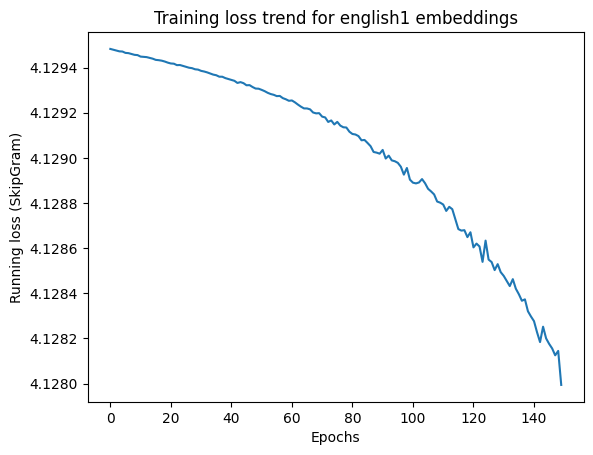

In [12]:
w2v = SkipGram_Embeddings_generator(train_hypo_datapath, train_hyper_datapath, "merged_english_vocab",OUTFILE="english1",iterations=150)
w2v.train()
w2v.write_logs()

In [13]:
english_embeddings_file = open("english1_sg_emb.txt", "r")
embeddings = english_embeddings_file.read().splitlines()
training_set = "1A.english.training.data.txt"
training_hypernym_set = "1A.english.training.gold.txt"
testing_set = "1A.english.test.data.txt"
testing_hypernym_set = "1A.english.test.gold.txt"
validation_set = "1A.english.trial.data.txt"
validation_hypernym_set = "1A.english.trial.gold.txt"
hypernyms_to_be_saved_for_trainset_data = "train_predicted_hypernym_lstm_english.txt"
hypernyms_to_be_saved_for_testset_data = "test_predicted_hypernym_lstm_english.txt"

In [14]:
vocab_size = len(embeddings)

In [15]:
embedding_matrix = np.zeros((vocab_size, 300))  # as the size of embedding vector is 300
counter = 1
word_vocab = []
word_vocab.append("UNK")
embedding_matrix[0] = np.random.random(300)

In [16]:
for word_embed in embeddings[1:]:
        word_vocab.append(word_embed.split()[0])
        temp_embedding = word_embed.strip().split(' ')[1:]
        temp_array = np.zeros(shape=(1, 300))

        for i in range(len(temp_embedding)):
            temp_array[0, i] = float(temp_embedding[i])
        embedding_matrix[counter] = temp_array[0]
        counter = counter + 1

In [17]:
queryset_file = open(training_set, "r")
queryset = queryset_file.readlines()
queryset_test_file = open(testing_set, "r")
queryset_test = queryset_test_file.readlines()
queryset_validation_file = open(validation_set, "r")
queryset_validation = queryset_validation_file.readlines()

In [18]:
import random

In [19]:
for i in range(len(queryset)):
    queryset[i] = "_".join(queryset[i].split("\t")[0].split())

for i in range(len(queryset_test)):
    queryset_test[i] = "_".join(queryset_test[i].split("\t")[0].split())

for i in range(len(queryset_validation)):
    queryset_validation[i] = "_".join(queryset_validation[i].split("\t")[0].split())

In [20]:
training_hypernym_file = open(training_hypernym_set, "r")
training_hypernyms = training_hypernym_file.read().splitlines() 

testing_hypernym_file = open(testing_hypernym_set, "r")
testing_hypernyms = testing_hypernym_file.read().splitlines() 

validation_hypernym_file = open(validation_hypernym_set, "r")
validation_hypernyms = validation_hypernym_file.read().splitlines() 

In [21]:
def prepare_Dataset(queryset, word_vocab, hypernyms_tab_sep, embedding_matrix):
    query_hypernym_training_embedding = np.zeros((1, 2, 300))
    y_label = np.array([])
    counter = 0
    for i in range(len(queryset)):
        if queryset[i] in word_vocab:
            index = word_vocab.index(queryset[i])
            query_embedd = embedding_matrix[index]
            for hypernyms_found in hypernyms_tab_sep[i].split("\t"):
                hypernyms_found = "_".join(hypernyms_found.split())
                if hypernyms_found in word_vocab:
                    hypernym_index = word_vocab.index(hypernyms_found)

                    hypernym_embedd = embedding_matrix[hypernym_index] 
                    vec_temp = np.vstack((query_embedd, hypernym_embedd)).reshape(1, 2, -1)
                    query_hypernym_training_embedding = np.concatenate((query_hypernym_training_embedding, vec_temp),
                                                                       axis=0)  # Merging
                    y_label = np.append(y_label, 1)  
                    negative_samples_counter = 0
                    while negative_samples_counter < 5:  # 5 negative samples per positive sample
                        random_index = random.randint(0, len(word_vocab) - 1)
                        if random_index != index:
                            hypernym_embedd = embedding_matrix[random_index]
                            vec_temp = np.vstack((query_embedd, hypernym_embedd)).reshape(1, 2, -1)
                            query_hypernym_training_embedding = np.concatenate(
                                (query_hypernym_training_embedding, vec_temp), axis=0)  # Merging
                            y_label = np.append(y_label,
                                                0)  # inserting a negative label for each -ve hyponym-hypernym pair
                            counter = counter + 1
                            negative_samples_counter = negative_samples_counter + 1

                        else:
                            continue
                else:
                    print(hypernyms_found)
                    query_embedd = embedding_matrix[index]
                    hypernym_index = 0
                    print(counter)
                    hypernym_embedd = embedding_matrix[hypernym_index]
                    vec_temp = np.vstack((query_embedd, hypernym_embedd)).reshape(1, 2, -1)
                    query_hypernym_training_embedding = np.concatenate((query_hypernym_training_embedding, vec_temp),
                                                                       axis=0)  # Merging
                    y_label = np.append(y_label, 1)  # inserting a positive label for each +ve hyponym-hypernym pair
                    # generating 5 -ve samples per correct pair
                    negative_samples_counter = 0
                    while negative_samples_counter < 5:  # 5 negative samples per positive sample
                        random_index = random.randint(0, len(word_vocab) - 1)
                        if random_index != index:
                            hypernym_embedd = embedding_matrix[random_index]
                            vec_temp = np.vstack((query_embedd, hypernym_embedd)).reshape(1, 2, -1)
                            query_hypernym_training_embedding = np.concatenate(
                                (query_hypernym_training_embedding, vec_temp), axis=0)  # Merging
                            y_label = np.append(y_label,
                                                0)  # inserting a negative label for each -ve hyponym-hypernym pair
                            counter = counter + 1
                            negative_samples_counter = negative_samples_counter + 1

                        else:
                            continue

    # deleting the unpopulated cells of the array i.e the ones that contained zeros
    query_hypernym_training_embedding = query_hypernym_training_embedding[1:, :, :]
    # shuffling the query_hypernym_pair and labels randomly before training
    list_for_shuffling = list(zip(query_hypernym_training_embedding, y_label))
    random.shuffle(list_for_shuffling)
    training_query_hypernym_pair, y_train = zip(*list_for_shuffling)
    return query_hypernym_training_embedding, y_label

In [27]:
training_query_hypernym_pair, y_train = prepare_Dataset(queryset, word_vocab, training_hypernyms,embedding_matrix)
testing_query_hypernym_pair, y_test = prepare_Dataset(queryset_test, word_vocab, testing_hypernyms,embedding_matrix)
validation_query_hypernym_pair, y_validation = prepare_Dataset(queryset_validation, word_vocab,validation_hypernyms, embedding_matrix)

In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Embedding, Bidirectional, LSTM, TimeDistributed, Flatten, GRU
from keras.models import load_model
from keras.models import Model, Sequential

In [29]:
from matplotlib import pyplot as plt

Creating GRU model

In [32]:
def create_gru_model(loss_fn, adam_optimiser, training_query_hypernym_pair, y_train, testing_query_hypernym_pair,y_test, validation_query_hypernym_pair, y_validation):
    model = Sequential()
    model.add(Input(shape=(2, 300)))
    model.add(GRU(300, return_sequences=True, dropout=0.3))
    model.add(GRU(300, dropout=0.2))
    model.add(Flatten())
    model.add(Dense(300, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=loss_fn, optimizer=adam_optimiser, metrics=['accuracy'])
    history = model.fit(training_query_hypernym_pair, y_train, batch_size=64, epochs=20, verbose=2,
                        validation_data=(validation_query_hypernym_pair, y_validation))
    evaluation_test_set_score = model.evaluate(testing_query_hypernym_pair, y_test, batch_size=64)

    return model, history, evaluation_test_set_score


In [33]:
def gru_model_training(training_query_hypernym_pair, y_train, testing_query_hypernym_pair, y_test,validation_query_hypernym_pair, y_validation):
    loss_fn = tf.keras.losses.BinaryCrossentropy(
        from_logits=False,
        label_smoothing=0.0,
        axis=-1,
        name='binary_crossentropy')

    adam_optimiser = tf.keras.optimizers.Adam(learning_rate=0.003,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')
    model, history, evaluation_test_set_score = create_gru_model(loss_fn, adam_optimiser,training_query_hypernym_pair, y_train,testing_query_hypernym_pair, y_test,validation_query_hypernym_pair, y_validation)

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    print("------------------------------------------")
    print("Test Set Evaluation")
    print(evaluation_test_set_score)
    # saving the trained model
    return model  # returning the model to the parent function

Epoch 1/20
650/650 - 40s - loss: 0.4150 - accuracy: 0.8417 - val_loss: 0.5360 - val_accuracy: 0.8301 - 40s/epoch - 62ms/step
Epoch 2/20
650/650 - 29s - loss: 0.3546 - accuracy: 0.8535 - val_loss: 0.5032 - val_accuracy: 0.8284 - 29s/epoch - 45ms/step
Epoch 3/20
650/650 - 30s - loss: 0.3336 - accuracy: 0.8569 - val_loss: 0.5614 - val_accuracy: 0.8301 - 30s/epoch - 46ms/step
Epoch 4/20
650/650 - 30s - loss: 0.3208 - accuracy: 0.8603 - val_loss: 0.5644 - val_accuracy: 0.8088 - 30s/epoch - 45ms/step
Epoch 5/20
650/650 - 29s - loss: 0.3112 - accuracy: 0.8627 - val_loss: 0.5876 - val_accuracy: 0.8203 - 29s/epoch - 45ms/step
Epoch 6/20
650/650 - 31s - loss: 0.3026 - accuracy: 0.8649 - val_loss: 0.6508 - val_accuracy: 0.8301 - 31s/epoch - 48ms/step
Epoch 7/20
650/650 - 29s - loss: 0.2984 - accuracy: 0.8664 - val_loss: 0.6329 - val_accuracy: 0.8203 - 29s/epoch - 45ms/step
Epoch 8/20
650/650 - 30s - loss: 0.2902 - accuracy: 0.8703 - val_loss: 0.6977 - val_accuracy: 0.8252 - 30s/epoch - 46ms/step


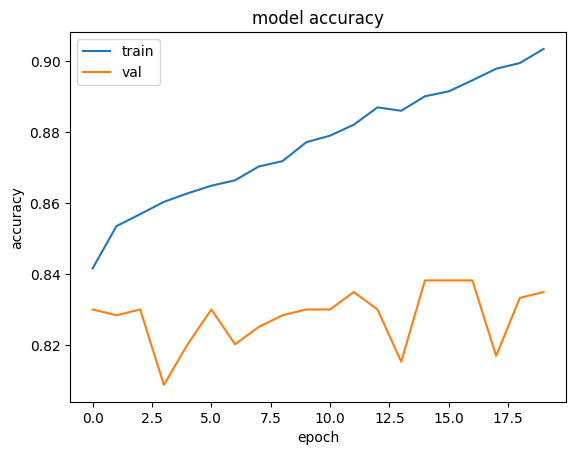

------------------------------------------
Test Set Evaluation
[0.8702733516693115, 0.8248932361602783]


In [ ]:
Trained_model = gru_model_training(training_query_hypernym_pair, y_train, testing_query_hypernym_pair, y_test,validation_query_hypernym_pair, y_validation)
# tf.saved_model.save(model, 'gru_model1')
# Trained_model.save('gru_model_1')
Trained_model.save('gru_model_9.h5')

## Hyperparameter tuning

| Model name | GRU layers | FC layers | batch size | epochs | dropout | Accuracy |
|----------------|:----------------|:----------------|:----------------|:----------------|:----------------|:----------------|  
|gru_model_1 | 1 | 1 | 32 | 10 | True | 81.21 |
|gru_model_2 | 1 | 1 | 32 | 20 | True | 82.75 |
|gru_model_3 | 1 | 1 | 64 | 20 | True | 84.33 |
|gru_model_4 | 2 | 1 | 32 | 10 | True | 77.70 |
|gru_model_5 | 2 | 1 | 32 | 20 | True | 83.97 |
|gru_model_6 | 2 | 1 | 64 | 20 | True | 82.67 |
|gru_model_7 | 2 | 2 | 32 | 10 | True | 83.81 |
|gru_model_8 | 2 | 2 | 32 | 20 | True | 80.32 |
|gru_model_9 | 2 | 2 | 64 | 20 | True | 82.48 |

In [35]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('/content/gru_model_3.h5')

In [36]:
history = model.fit(training_query_hypernym_pair, y_train, batch_size=32, epochs=10, verbose=2,
                        validation_data=(validation_query_hypernym_pair, y_validation))

Epoch 1/10
1300/1300 - 24s - loss: 0.3802 - accuracy: 0.8503 - val_loss: 0.4784 - val_accuracy: 0.8317 - 24s/epoch - 18ms/step
Epoch 2/10
1300/1300 - 22s - loss: 0.3344 - accuracy: 0.8627 - val_loss: 0.4840 - val_accuracy: 0.8333 - 22s/epoch - 17ms/step
Epoch 3/10
1300/1300 - 22s - loss: 0.3084 - accuracy: 0.8728 - val_loss: 0.4886 - val_accuracy: 0.8301 - 22s/epoch - 17ms/step
Epoch 4/10
1300/1300 - 32s - loss: 0.2934 - accuracy: 0.8776 - val_loss: 0.4952 - val_accuracy: 0.8382 - 32s/epoch - 24ms/step
Epoch 5/10
1300/1300 - 22s - loss: 0.2757 - accuracy: 0.8835 - val_loss: 0.4989 - val_accuracy: 0.8350 - 22s/epoch - 17ms/step
Epoch 6/10
1300/1300 - 22s - loss: 0.2599 - accuracy: 0.8911 - val_loss: 0.5015 - val_accuracy: 0.8415 - 22s/epoch - 17ms/step
Epoch 7/10
1300/1300 - 21s - loss: 0.2515 - accuracy: 0.8954 - val_loss: 0.5097 - val_accuracy: 0.8268 - 21s/epoch - 16ms/step
Epoch 8/10
1300/1300 - 23s - loss: 0.2411 - accuracy: 0.8997 - val_loss: 0.5466 - val_accuracy: 0.8366 - 23s/ep

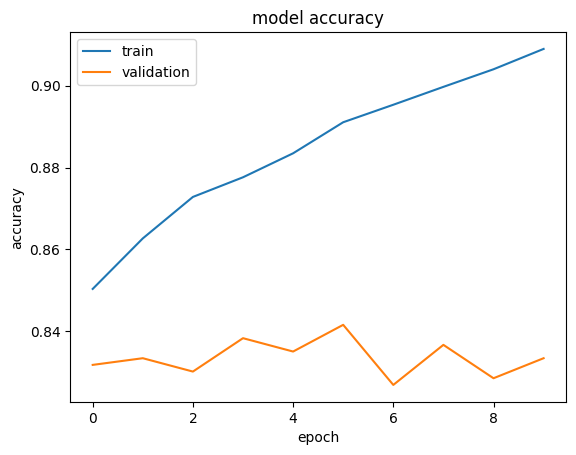

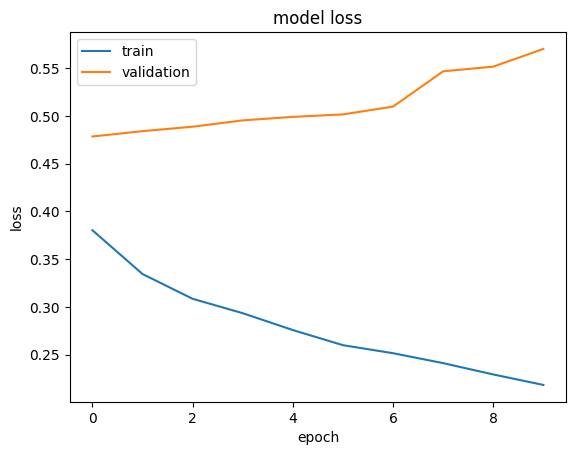

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()